### Imports

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.style
import matplotlib as mpl
import numpy as np

### Helper Methods


In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

mpl.rcParams['image.cmap'] = 'viridis'

def display_images(in_, out, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 4))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):

  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim, img_dim))
      ax.axis('off')

  plt.suptitle(title)
  plt.show()

In [3]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [4]:
batch_size = 256

In [9]:
# transformation to apply to each data point (image)
transformer = transforms.Compose(
    [transforms.ToTensor()])

# define the train and test datasets
ds_train = MNIST("./test", train=True, transform=transformer, download=True)
ds_test = MNIST("./test", train=False, transform=transformer)

# data loaders to load data in batches from the datasets
train_loader = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)
test_loader = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)

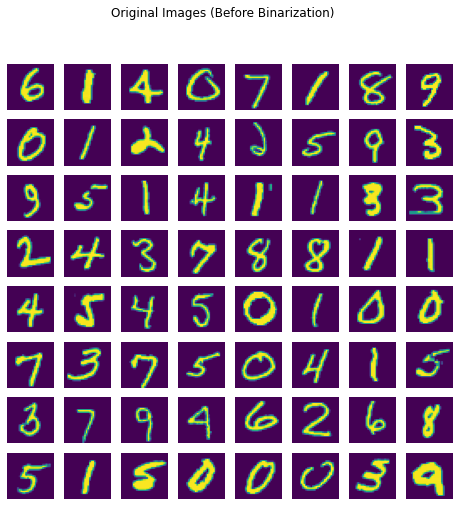

In [6]:
plot_samples_grid(train_loader, title='Original Images (Before Binarization)')

In [10]:
def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

# define the train and test datasets
bin_ds_train = MNIST("./bin_data", train=True, transform=binarizer, download=True)
bin_ds_test = MNIST("./bin_data", train=False, transform=binarizer)

# data loaders to load data in batches from the datasets
bin_train_loader = DataLoader(dataset=bin_ds_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)
bin_test_loader = DataLoader(dataset=bin_ds_test, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)


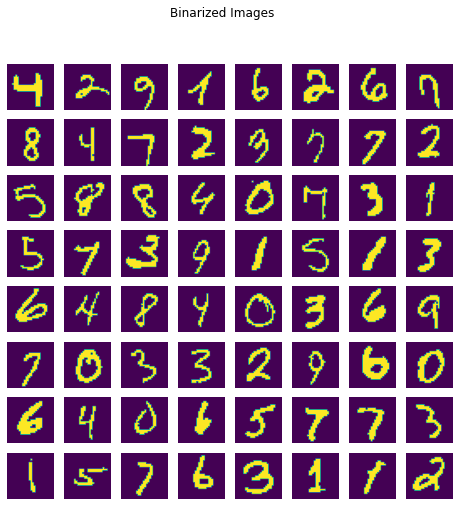

In [11]:
plot_samples_grid(bin_train_loader, title='Binarized Images')

In [12]:
latent_size = 20

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, latent_size)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [14]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

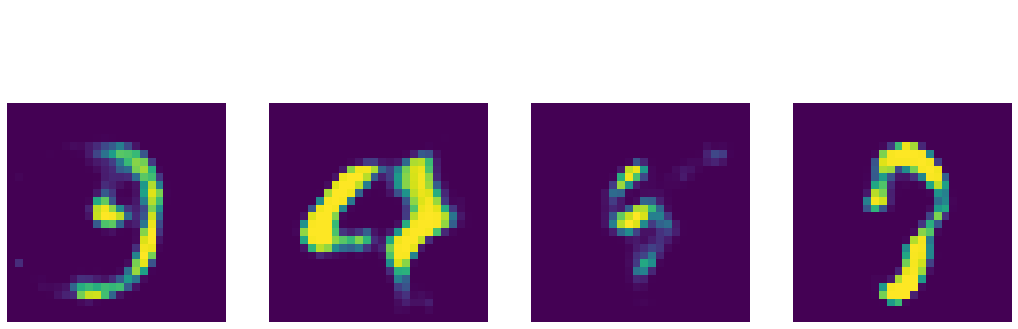

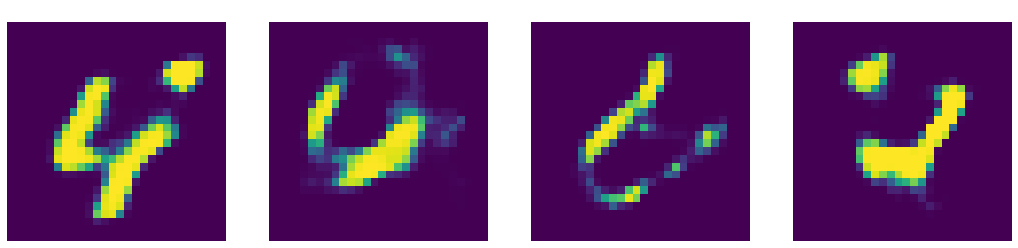

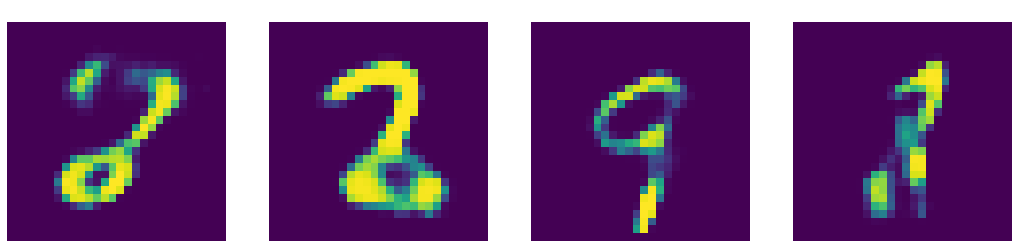

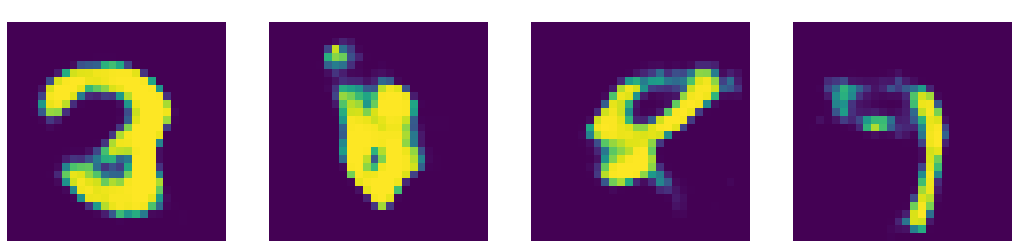

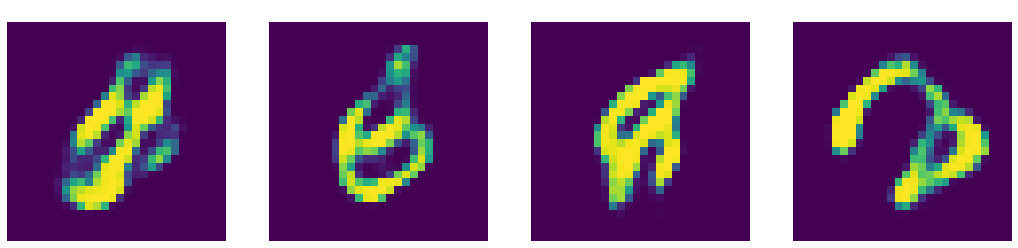

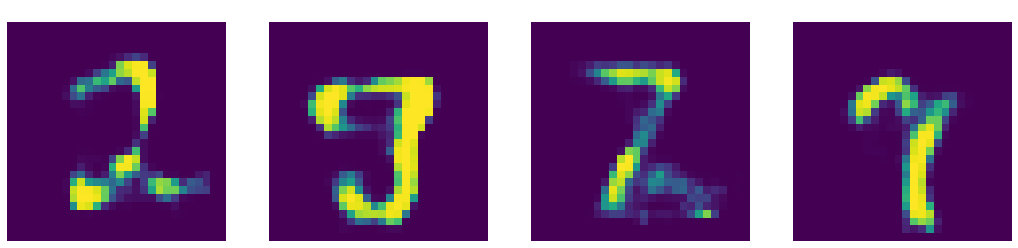

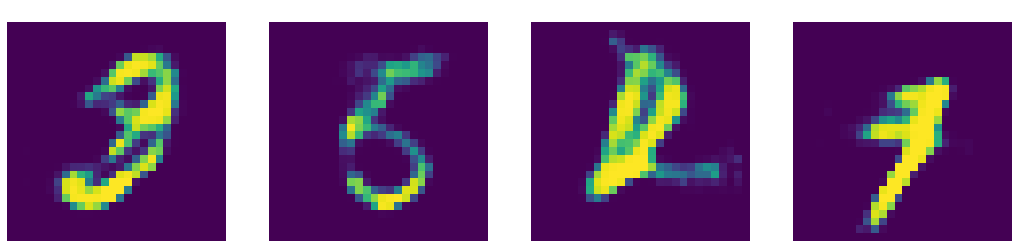

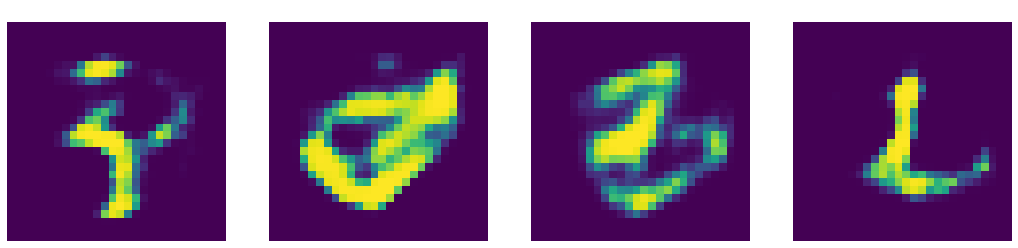

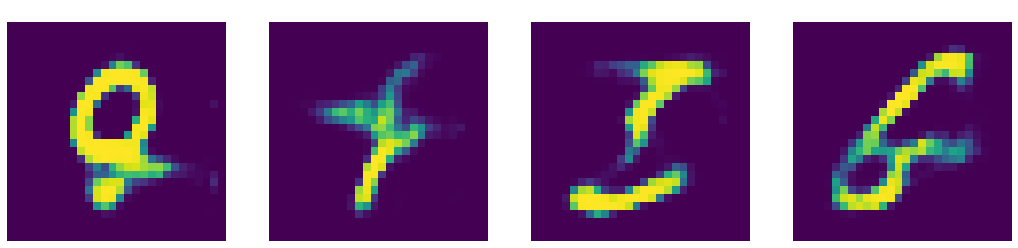

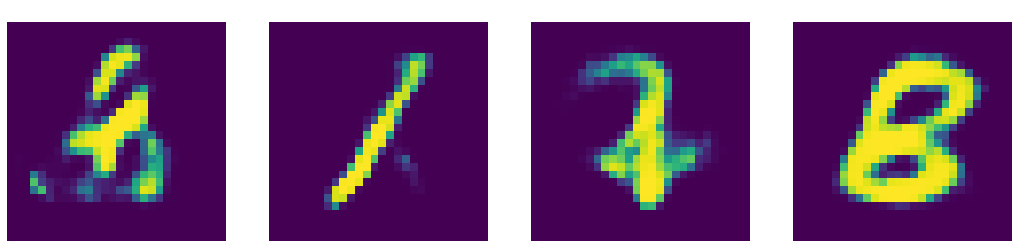

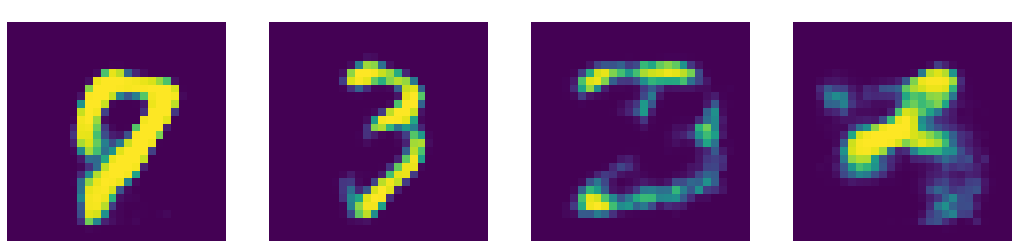

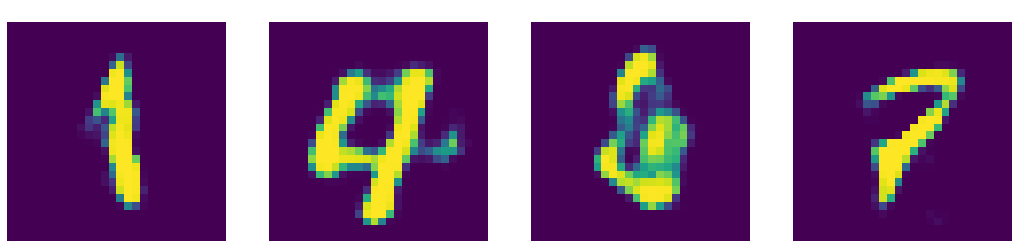

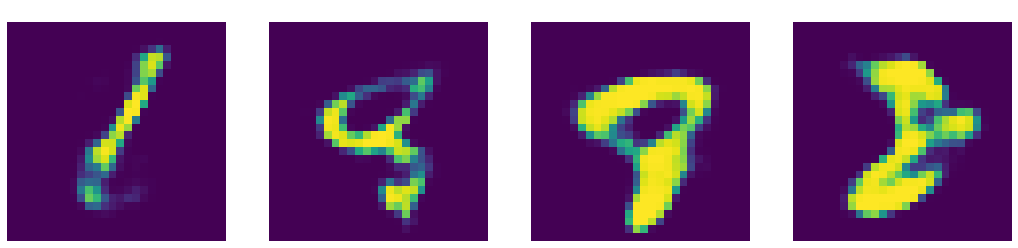

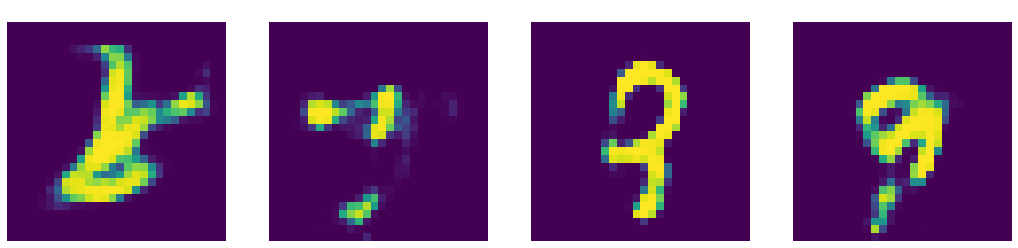

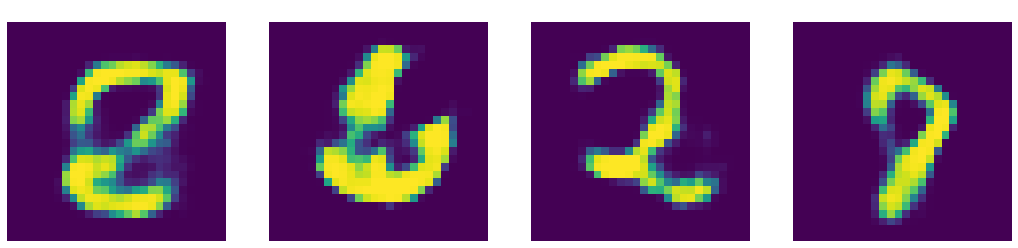

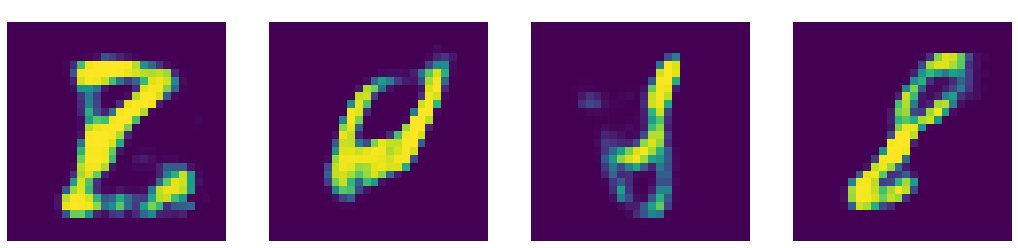

In [23]:
def loss_function(x_hat, x, mu, logvar):
    print(f"shape of x: {x.shape}")
    print(f"shape of x_hat: {x_hat.shape}")

    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )

    KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KL

samples = model.sample(64)
display_images(None, samples, 'Generated Samples - untrained Model', 64 // 4, count=True)

In [24]:
samples.shape

torch.Size([64, 784])

In [25]:
with torch.no_grad():
    model.eval()

    images, _ = next(iter(bin_train_loader))
    only_64 = images[0:64, :, :, :]
    only_64 = only_64.to(device)
    x_hat, mu, logvar = model(only_64)

    elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

shape of x: torch.Size([64, 1, 28, 28])
shape of x_hat: torch.Size([64, 784])
ELBO of 64 samples using the untrained model: 4583.5151


In [17]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for x, _ in bin_train_loader:
    x = x.to(device)
    # ===================forward=====================
    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# evaluates the model on the test set
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in bin_test_loader:
      x = x.to(device)
      # forward
      x_hat, mu, logvar = model(x)
      test_loss += loss_function(x_hat, x, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

====> Epoch: 1 Average train loss: 184.9834
====> Epoch: 1 Average test loss: 128.2780
====> Epoch: 2 Average train loss: 122.9760
====> Epoch: 2 Average test loss: 103.3883
====> Epoch: 3 Average train loss: 108.0828
====> Epoch: 3 Average test loss: 94.6051
====> Epoch: 4 Average train loss: 101.6818
====> Epoch: 4 Average test loss: 89.2998
====> Epoch: 5 Average train loss: 98.1224
====> Epoch: 5 Average test loss: 87.0769
====> Epoch: 6 Average train loss: 95.7144
====> Epoch: 6 Average test loss: 85.2191
====> Epoch: 7 Average train loss: 93.9478
====> Epoch: 7 Average test loss: 83.4148
====> Epoch: 8 Average train loss: 92.6108
====> Epoch: 8 Average test loss: 82.0259
====> Epoch: 9 Average train loss: 91.5098
====> Epoch: 9 Average test loss: 81.4510
====> Epoch: 10 Average train loss: 90.5476
====> Epoch: 10 Average test loss: 80.8989
====> Epoch: 11 Average train loss: 89.7590
====> Epoch: 11 Average test loss: 80.0964
====> Epoch: 12 Average train loss: 89.1744
====> Epoch

C:\Users\Josip\AppData\Local\Temp/ipykernel_14324/185422004.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


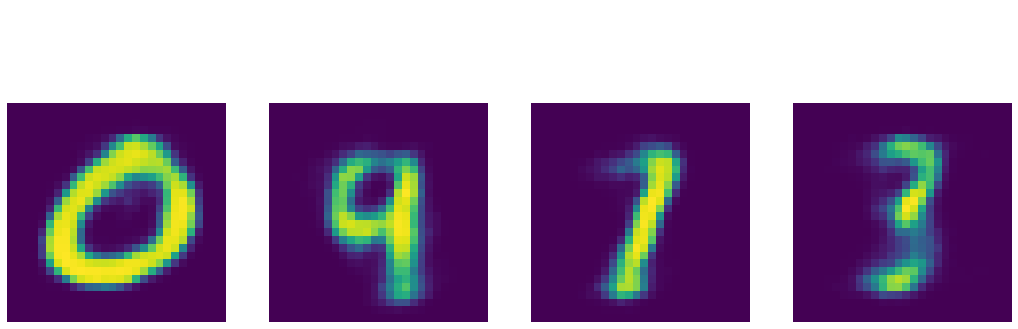

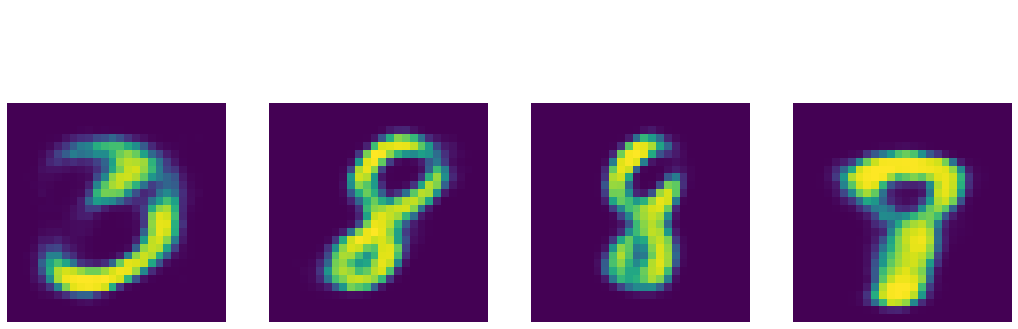

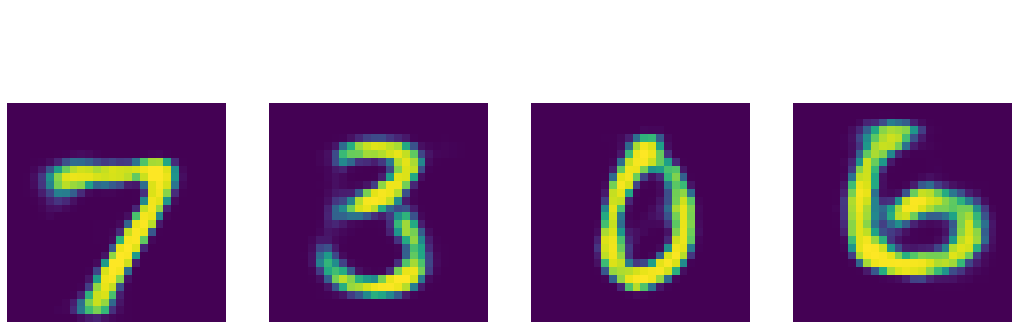

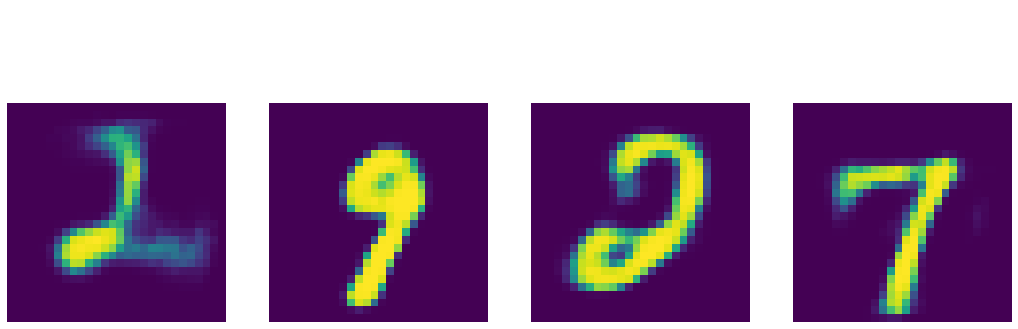

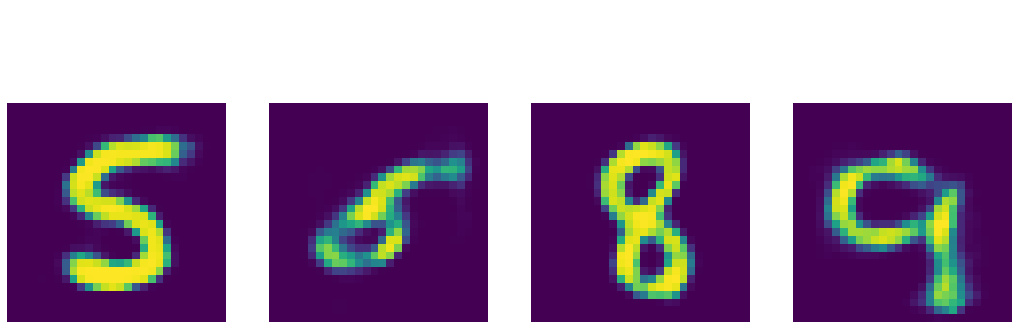

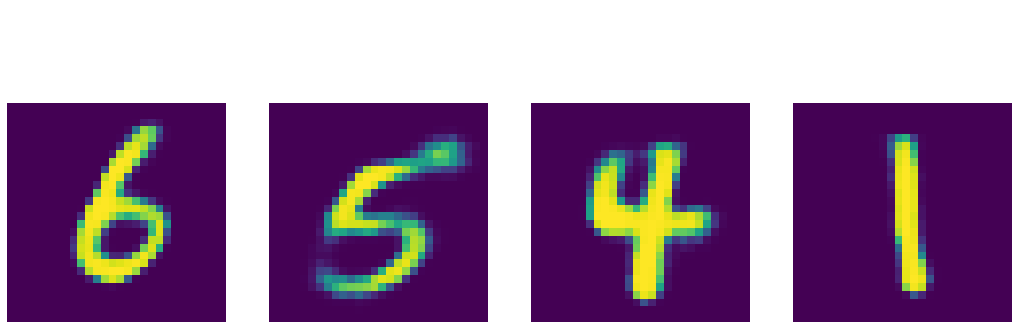

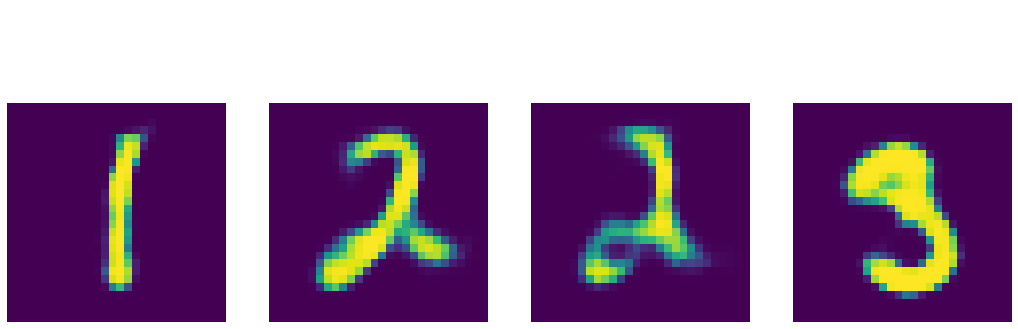

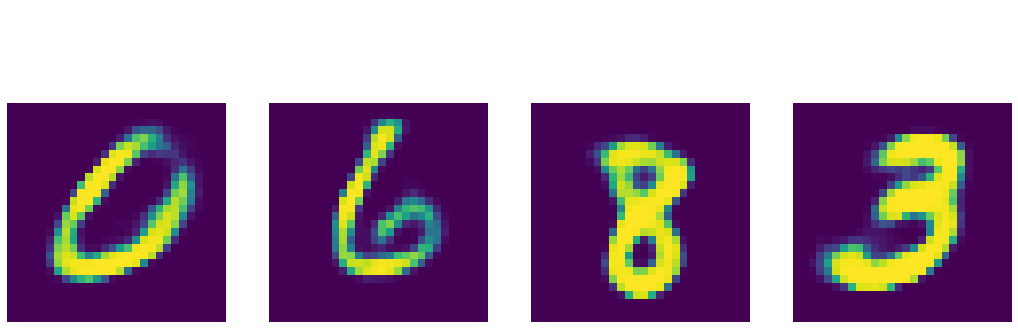

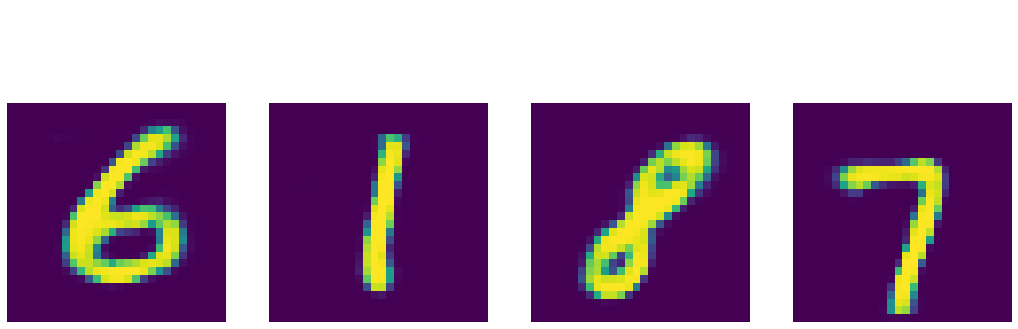

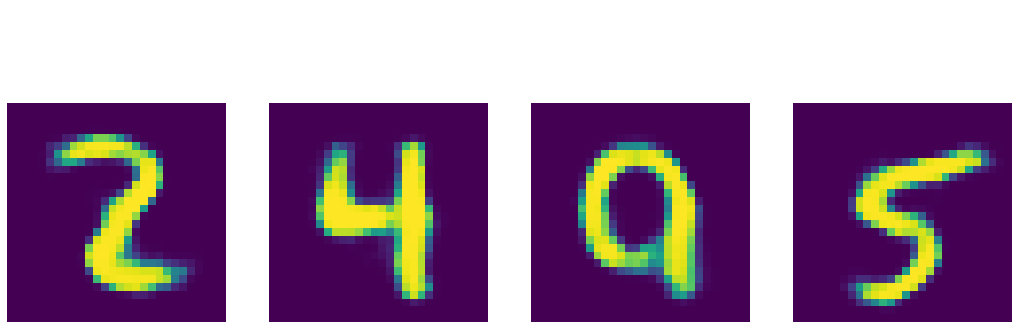

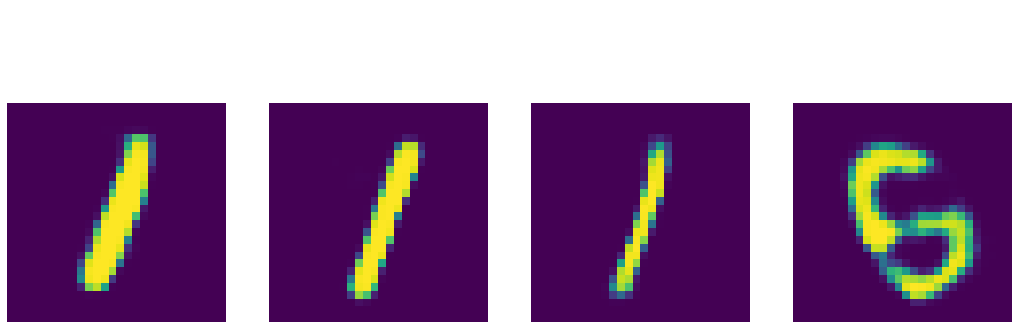

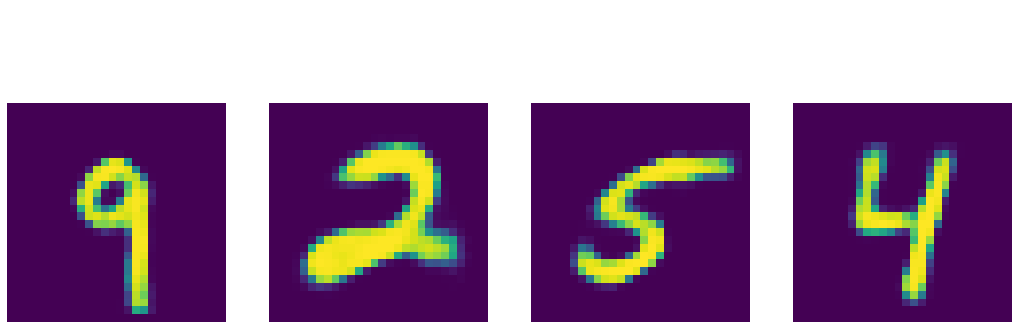

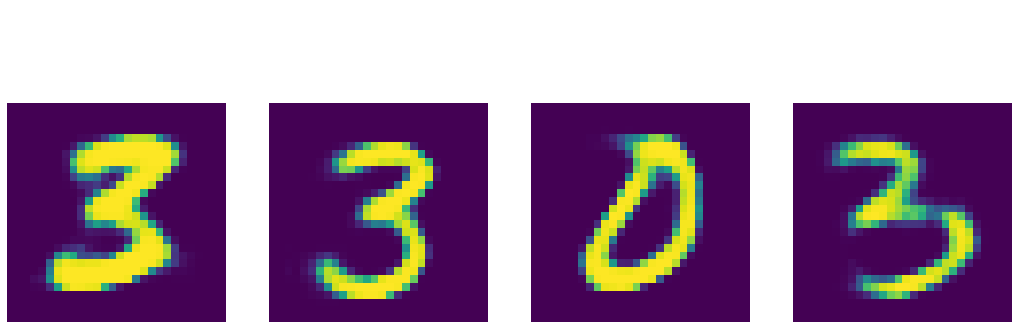

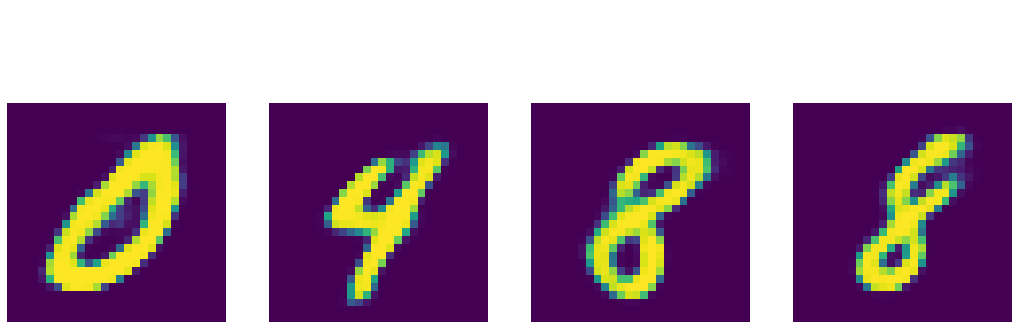

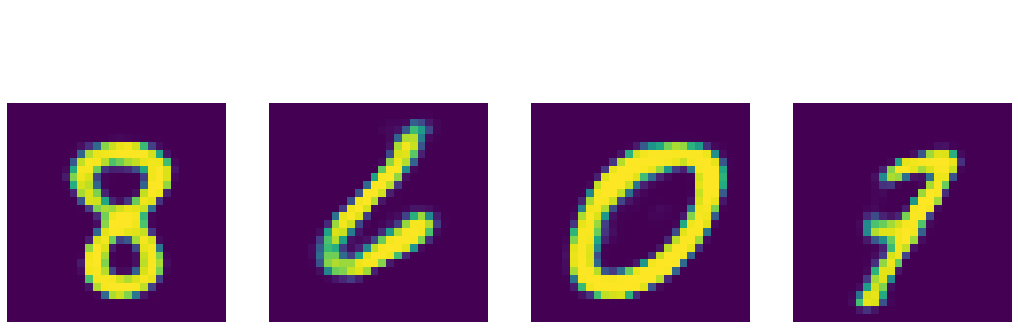

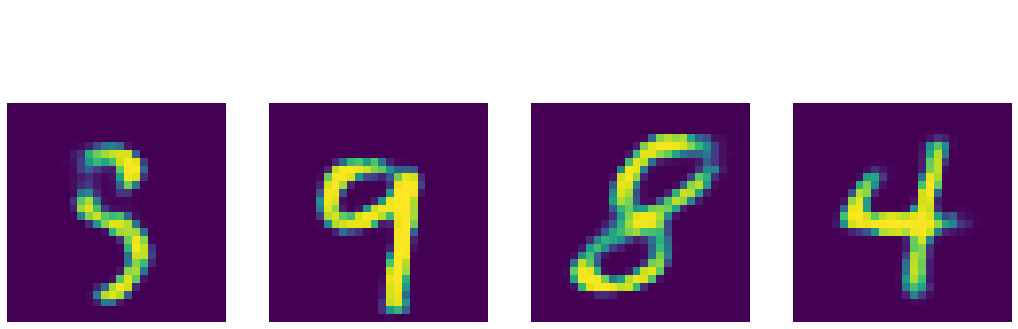

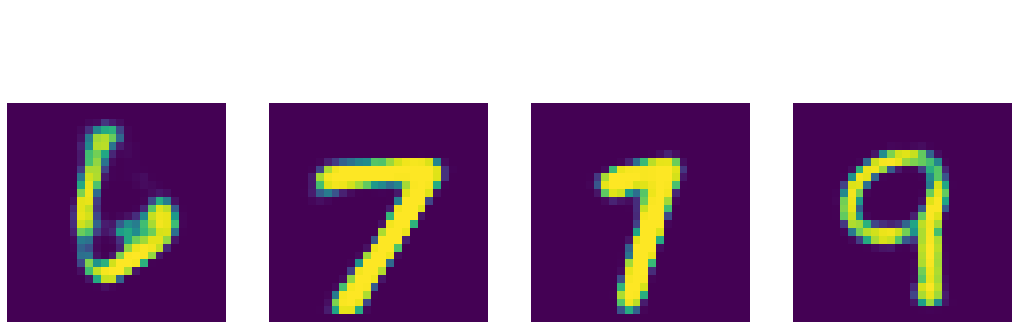

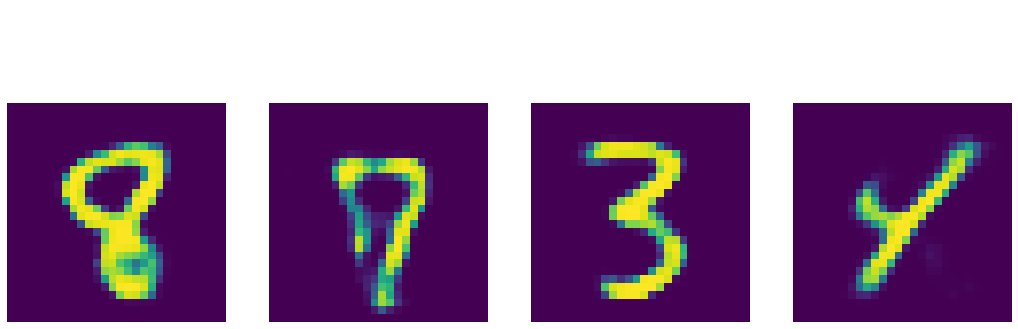

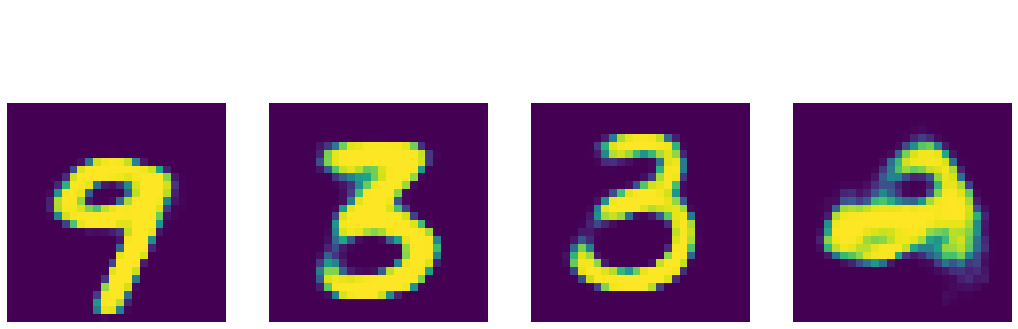

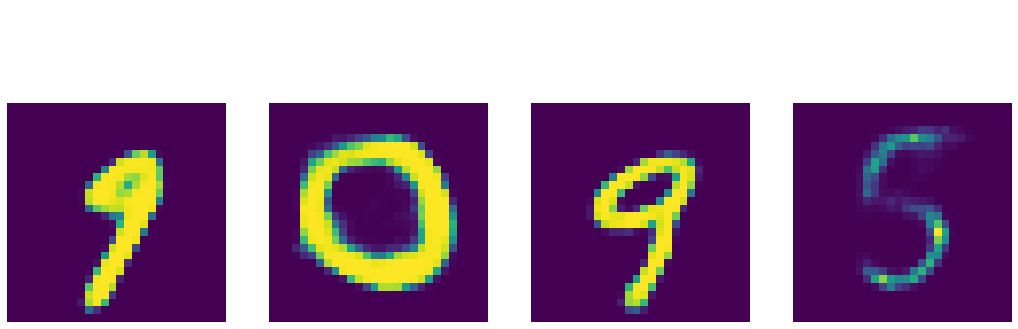

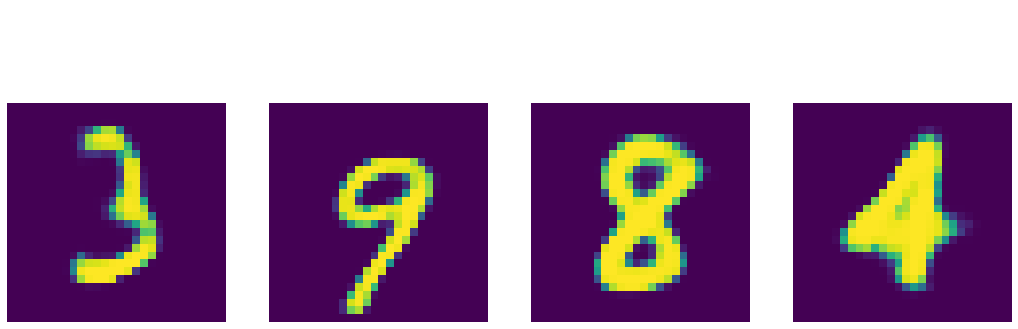

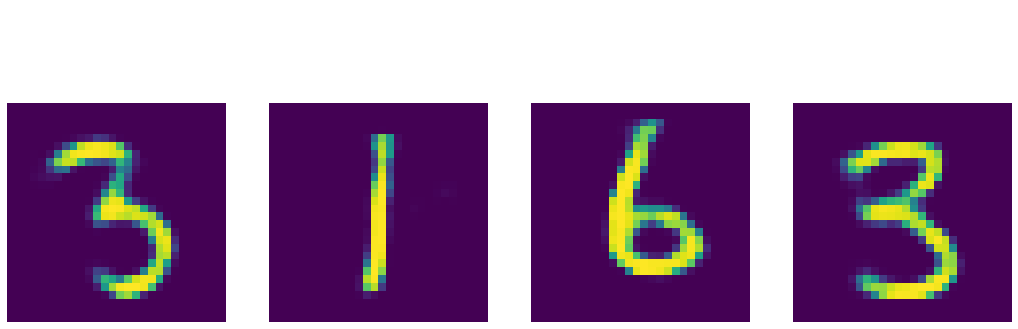

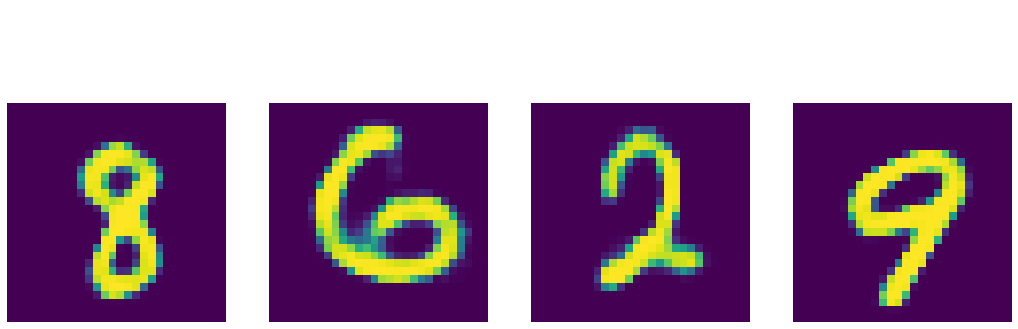

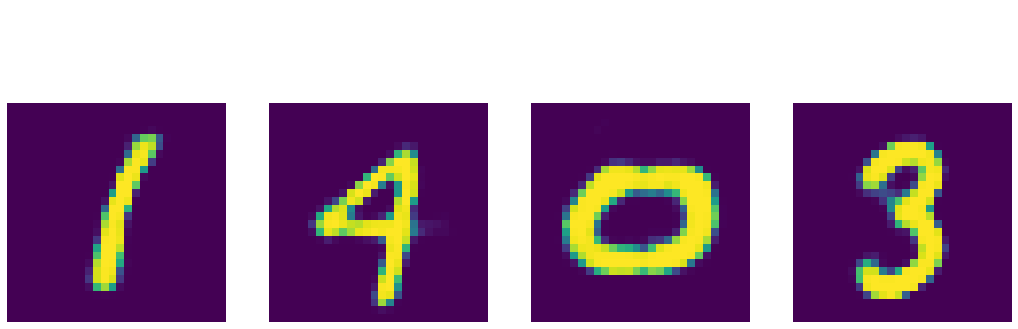

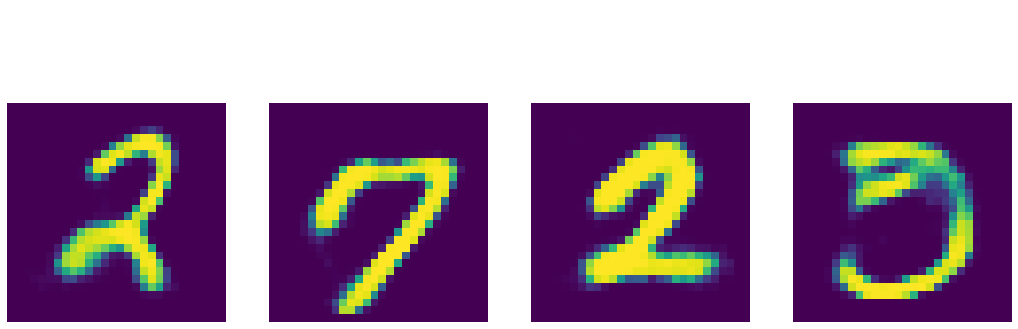

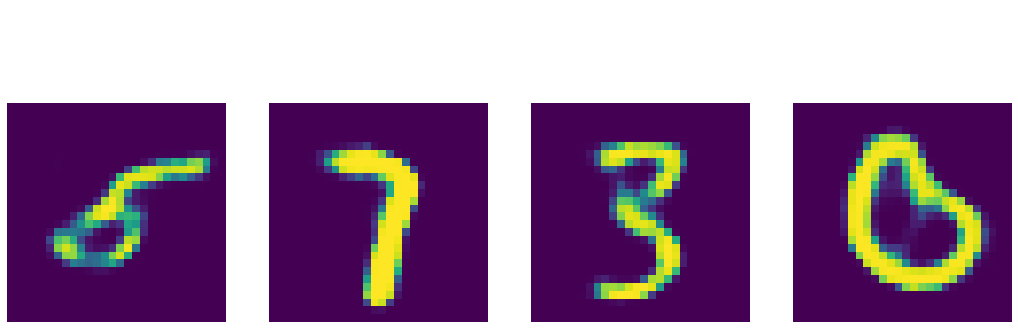

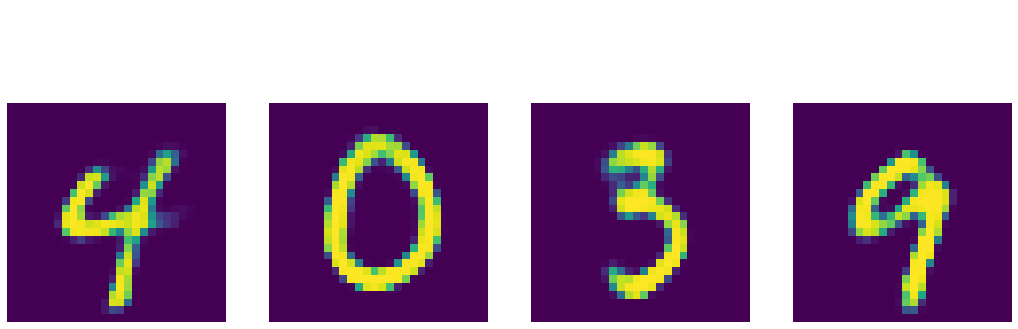

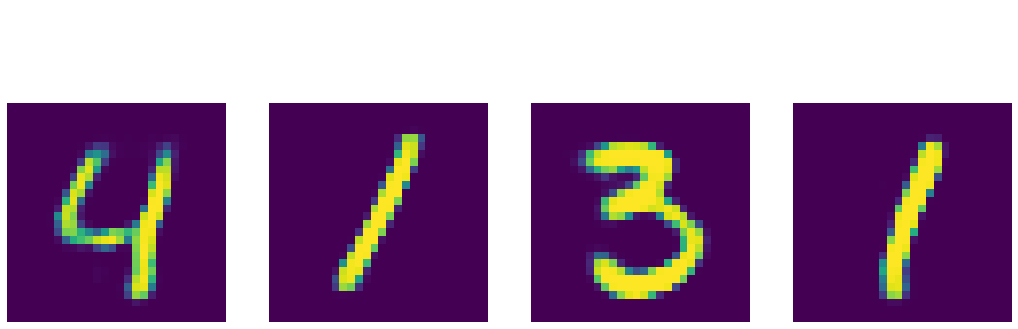

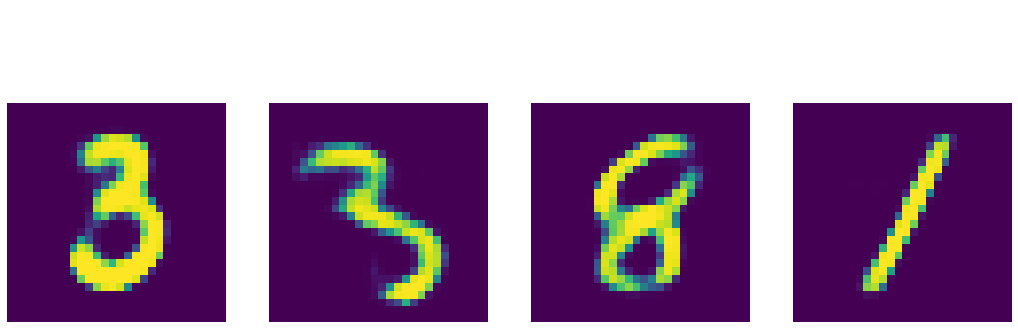

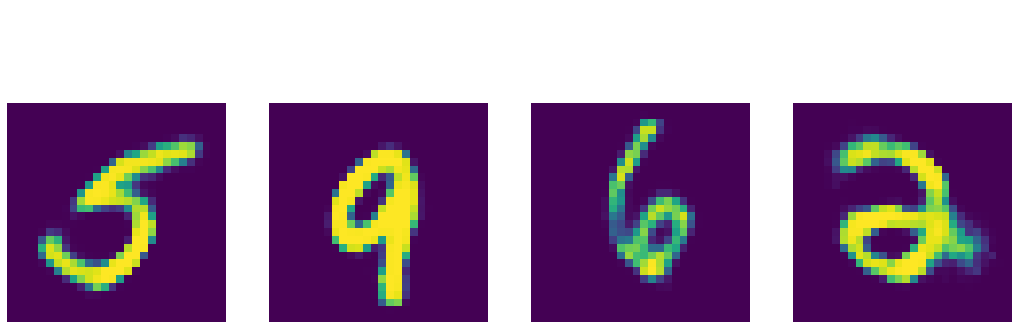

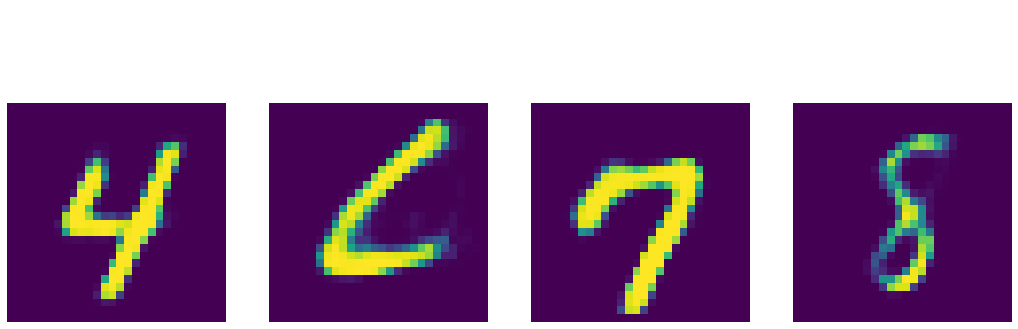

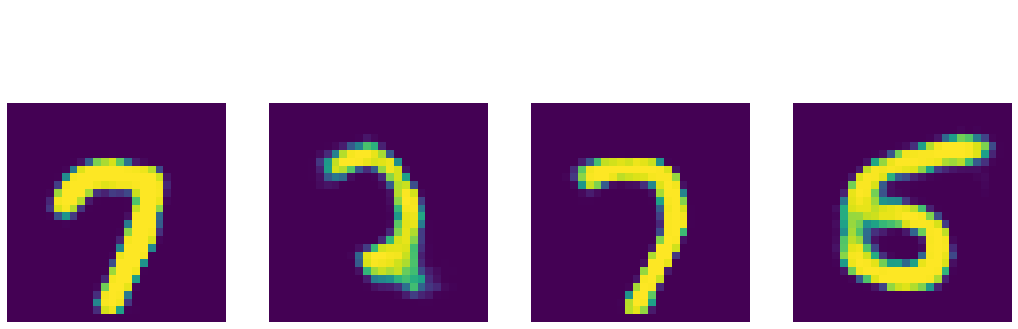

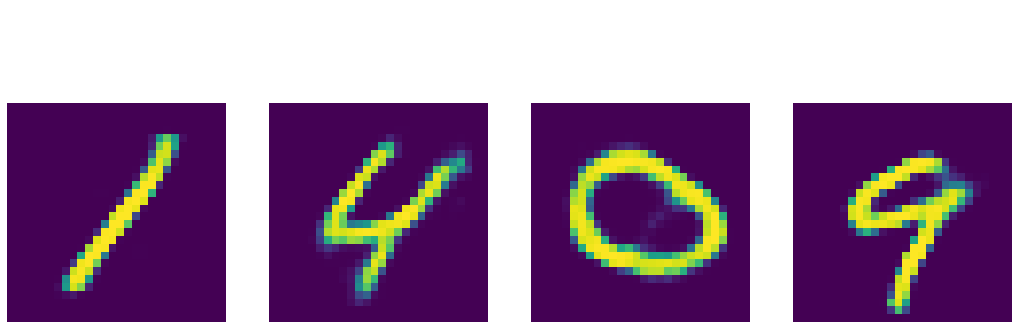

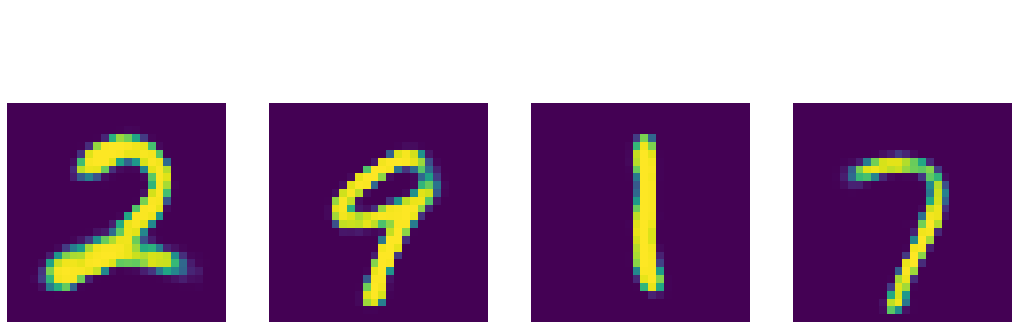

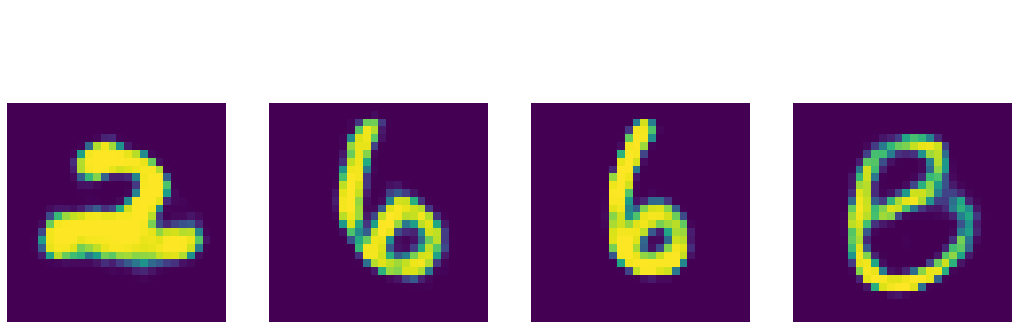

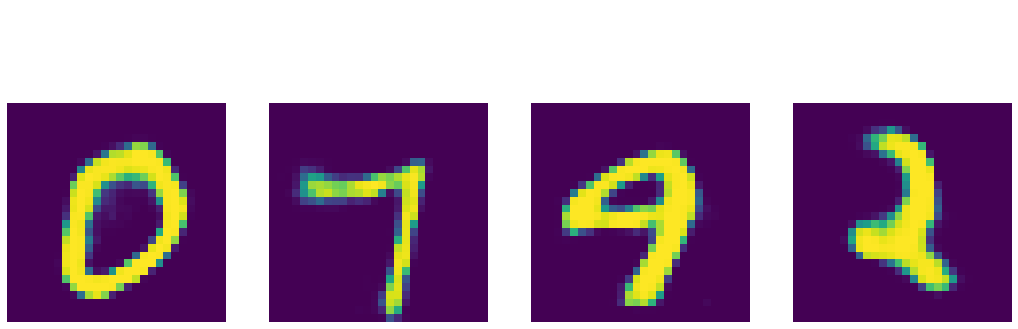

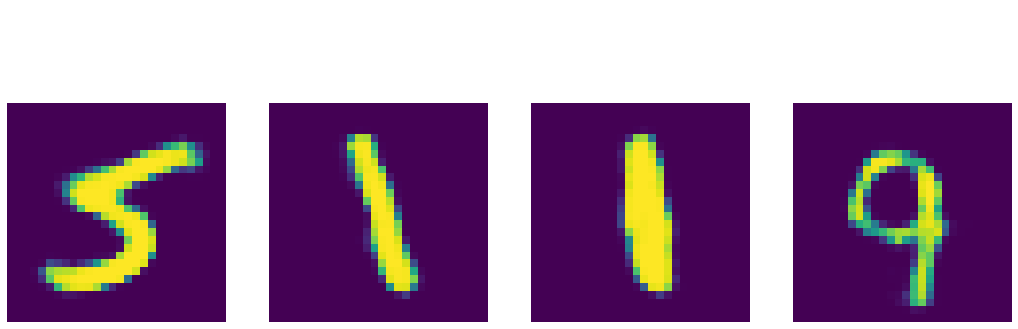

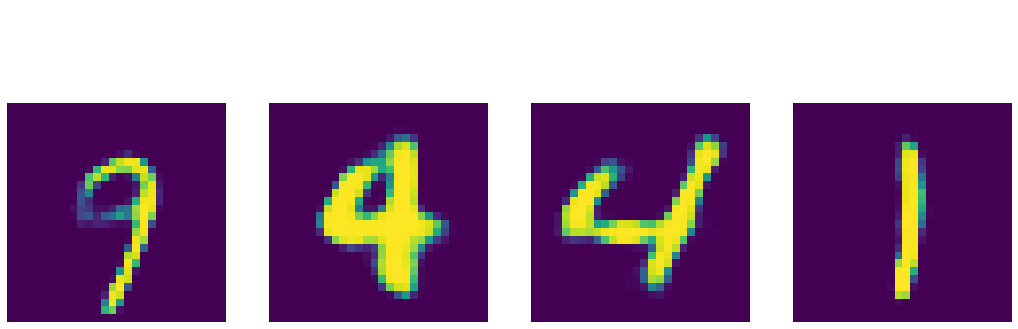

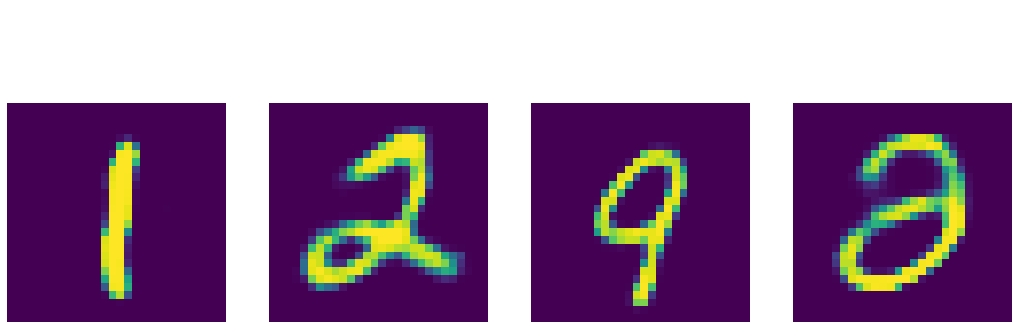

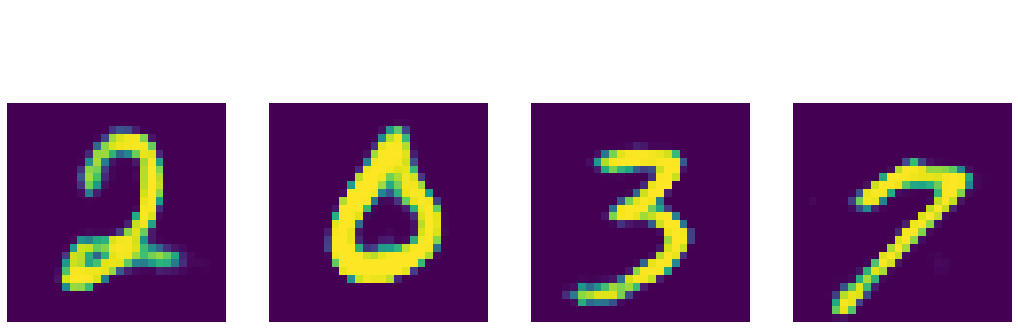

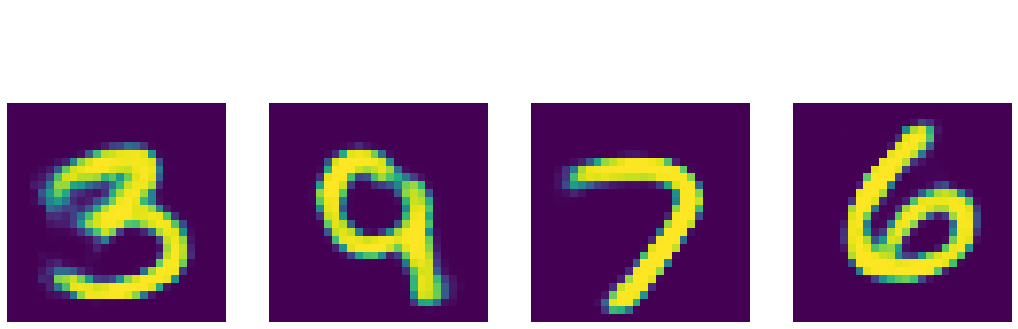

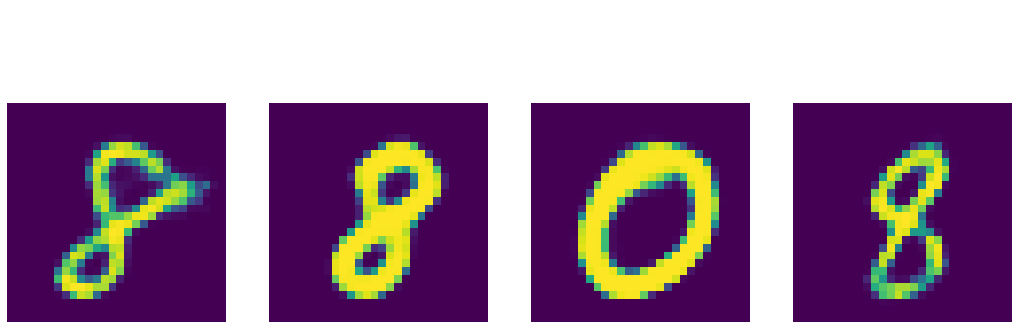

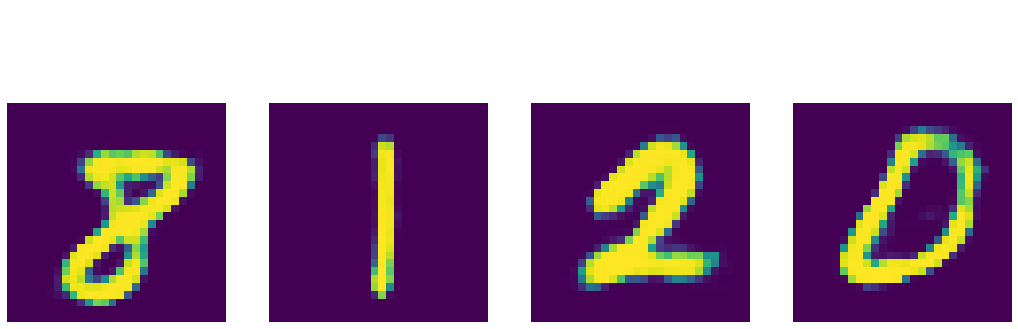

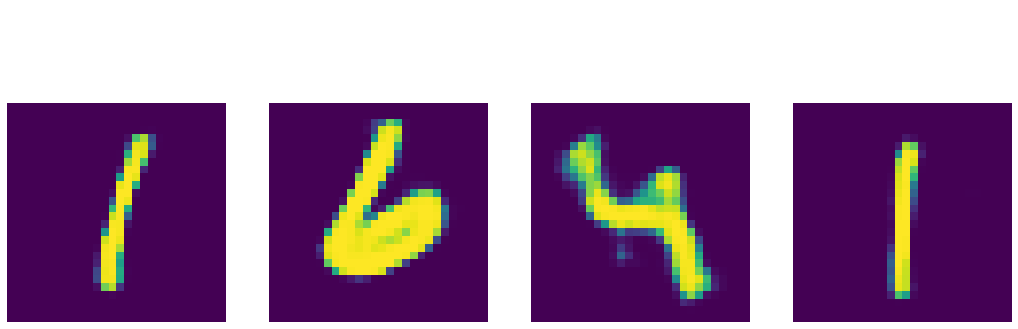

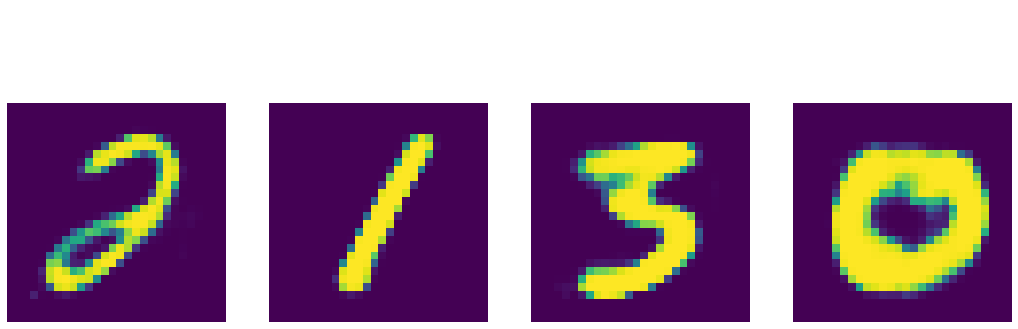

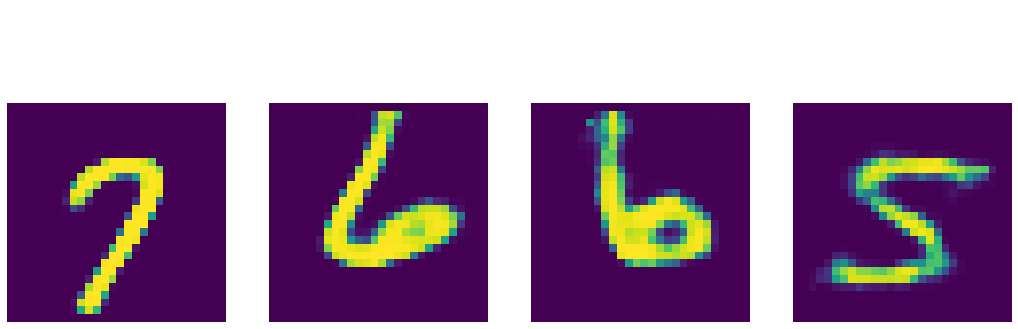

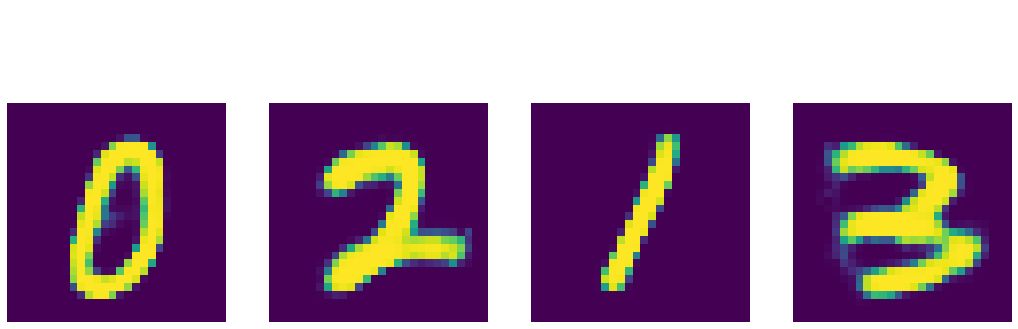

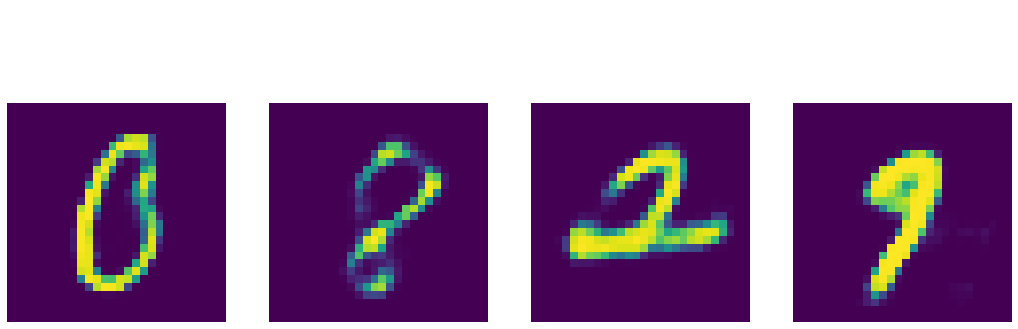

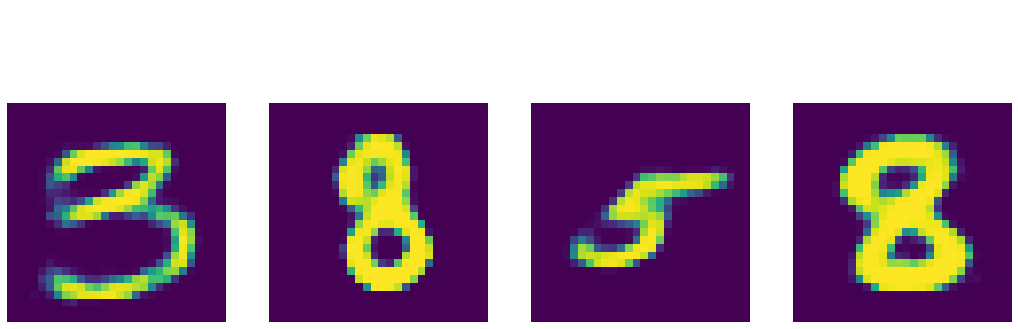

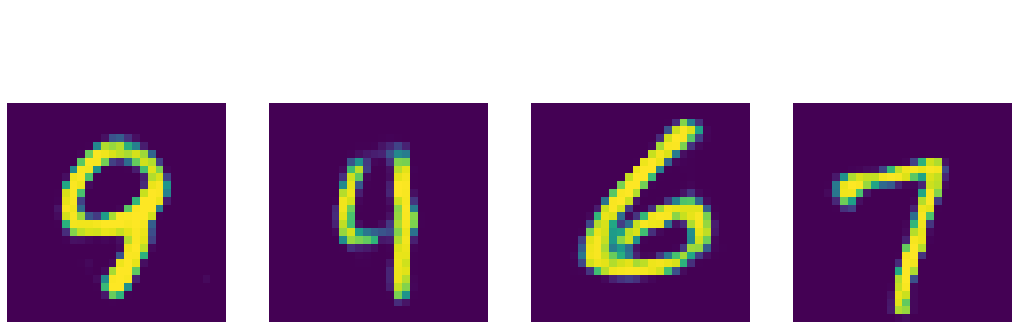

In [18]:
# Training the model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):

    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(bin_train_loader.dataset):.4f}')

    # evaluate this epoch over the test set
    test_loss, means, logvars, labels, images = test(epoch)

    # log for analysis
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(bin_test_loader.dataset):.4f}')

In [19]:
torch.save(model.state_dict(), 'vae-model.pt')

In [20]:
model = VAE().to(device)
model.load_state_dict(torch.load('vae-model.pt'))

<All keys matched successfully>

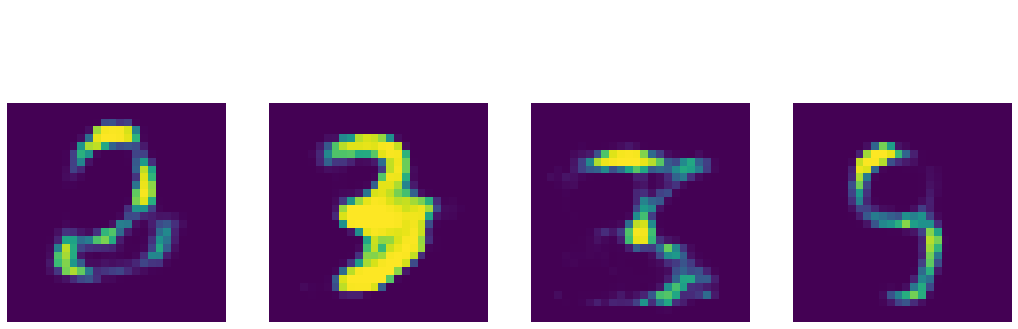

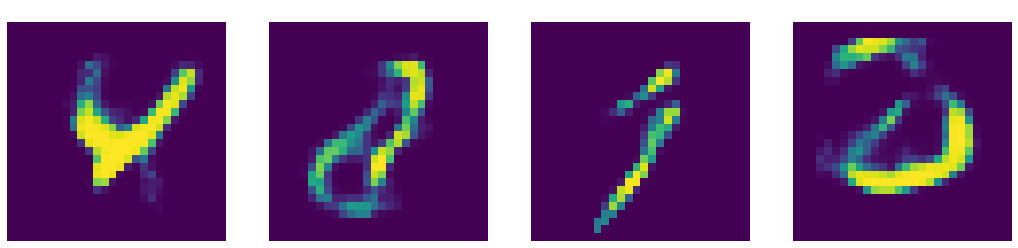

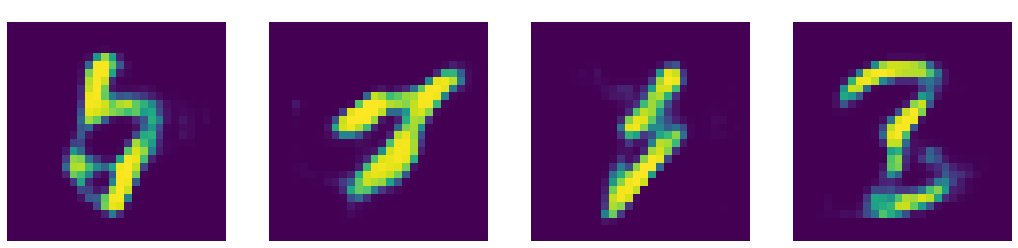

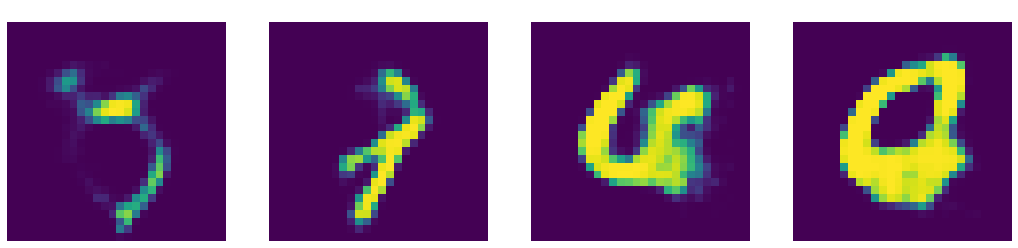

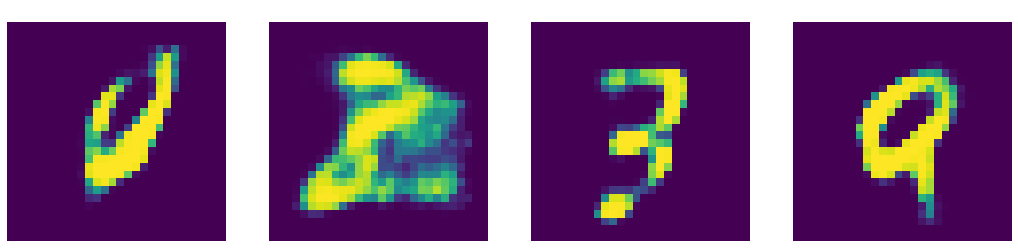

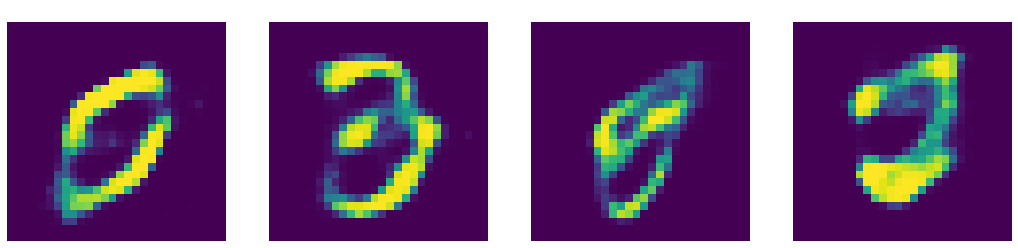

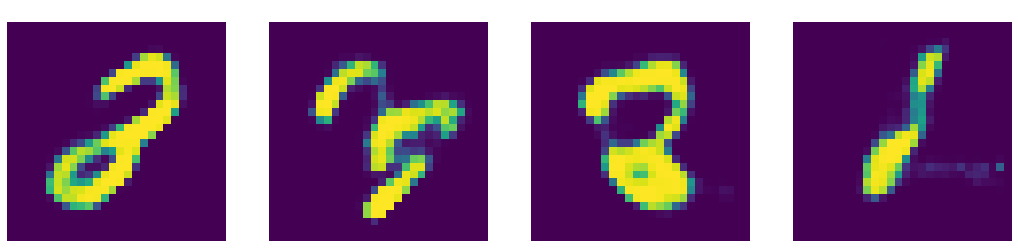

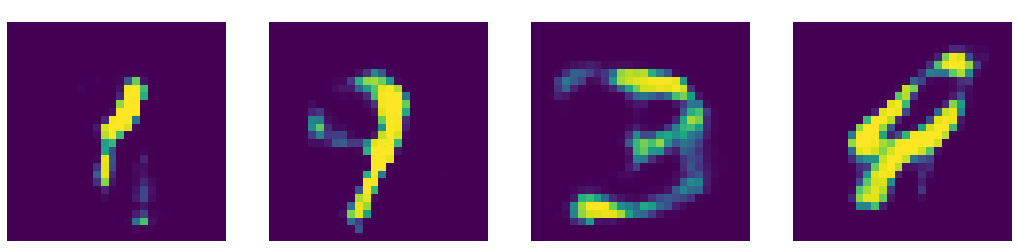

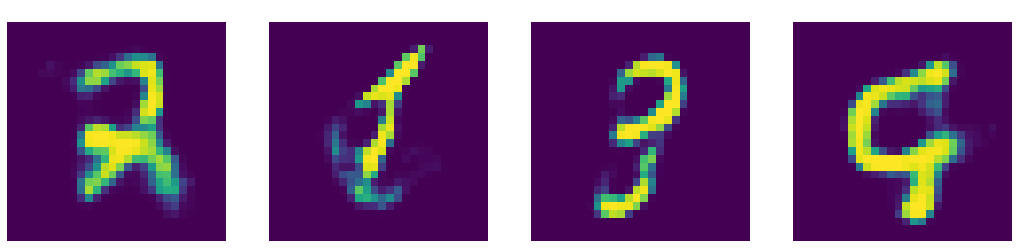

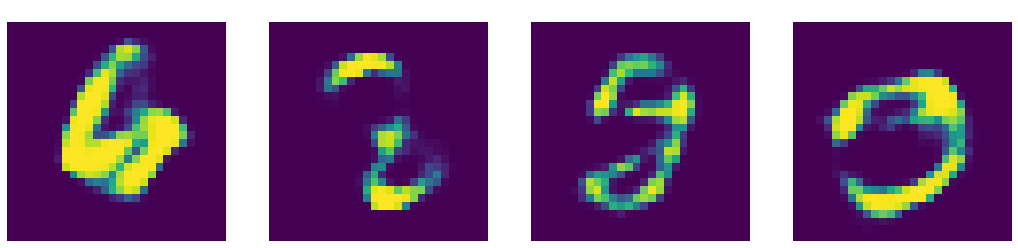

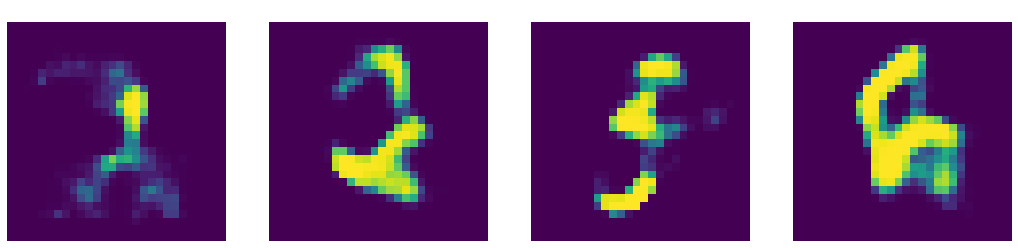

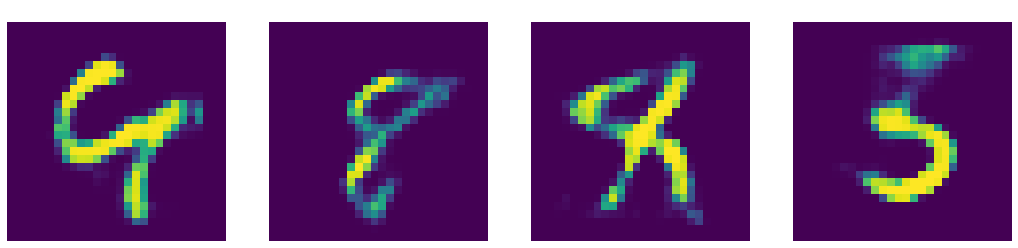

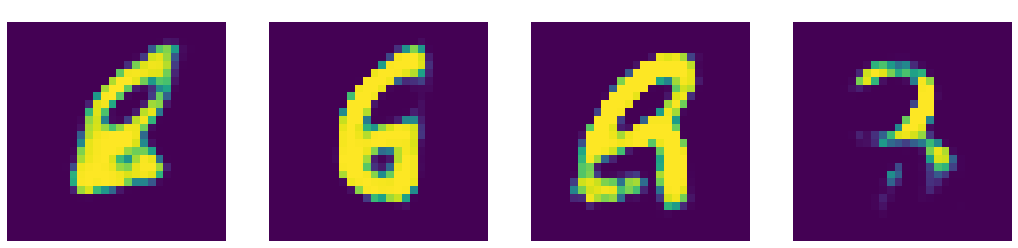

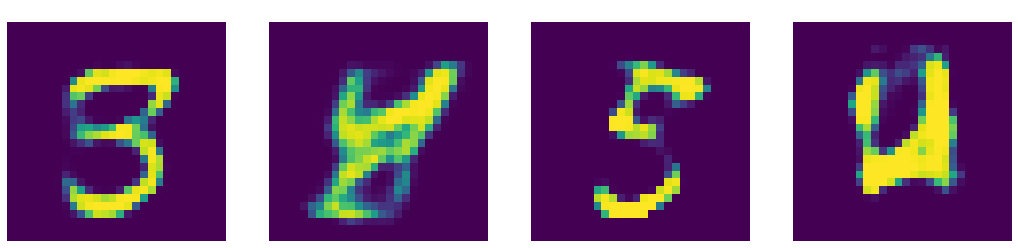

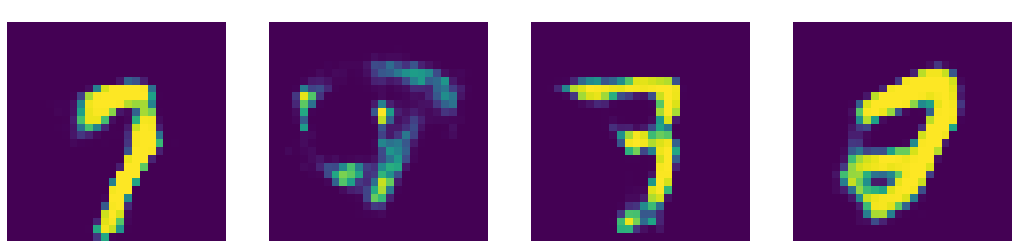

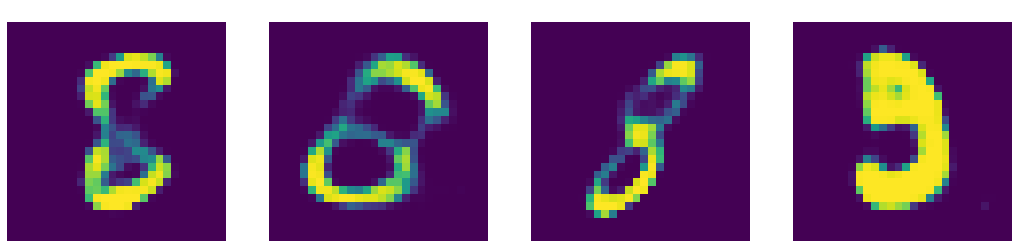

In [21]:
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True)